# Определение возраста покупателей

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

# Цель проекта
Построите модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [1]:
#Импортируем библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
plt.rcParams["figure.figsize"] = (15,15)

In [2]:
#Загружаем датасет
labels = pd.read_csv('/datasets/faces/labels.csv')
batch_size = 32
img_width = 180
img_height = 180
datagen = ImageDataGenerator(rescale=1./255)
datagen_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
#Изучаем данные
def data(dataset):
    print(labels.info()),
    print()
    print(labels.shape),
    print()
    print(labels.describe())

print(data(labels))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

(7591, 2)

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000
None


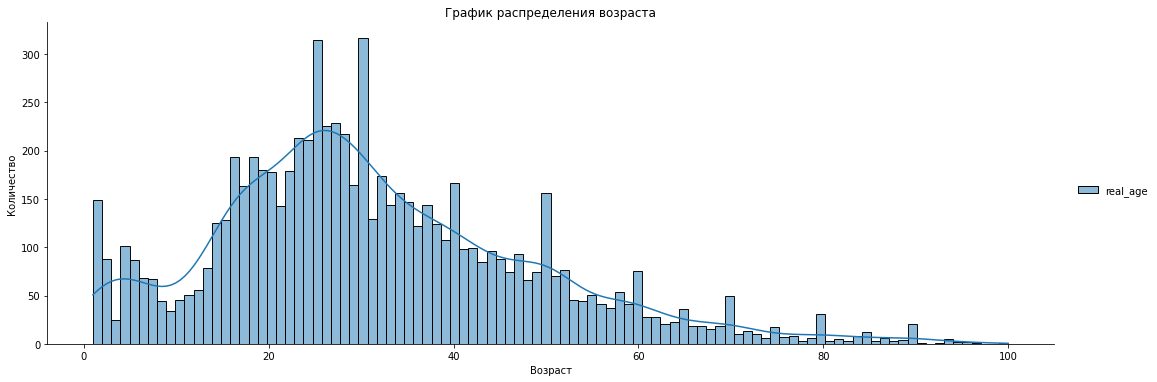

In [4]:
#Получаем график по категориальным признакам
sns.displot(labels,kde=True,bins=100,aspect=3)
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

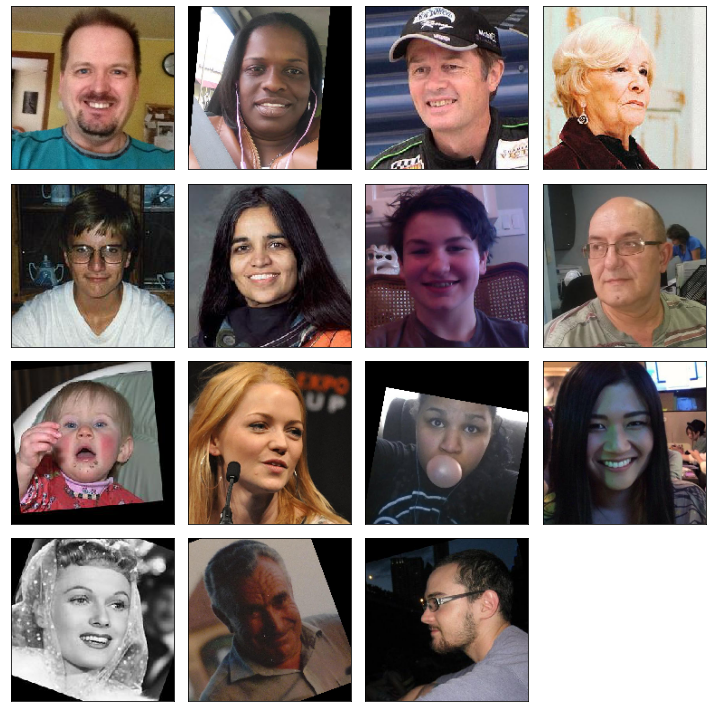

In [5]:
#Выводим 15 фото на экран
features, target = next(datagen_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

1. В среднем возраст варируется от 20-41а. 
2. Фотографии и цветные, и чёрно-белые, Есть фотографии под углом.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

#Импортируем библиотеки
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,horizontal_flip=True, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 63s - loss: 296.7882 - mae: 12.6154 - val_loss: 794.5312 - val_mae: 23.2435
Epoch 2/10
356/356 - 38s - loss: 77.0878 - mae: 6.7419 - val_loss: 135.5688 - val_mae: 8.7709
Epoch 3/10
356/356 - 38s - loss: 40.5287 - mae: 4.9222 - val_loss: 97.3263 - val_mae: 7.3805
Epoch 4/10
356/356 - 38s - loss: 26.1303 - mae: 3.9357 - val_loss: 76.1431 - val_mae: 6.6915
Epoch 5/10
356/356 - 38s - loss: 18.6278 - mae: 3.3347 - val_loss: 74.5112 - val_mae: 6.5567
Epoch 6/10
356/356 - 38s - loss: 15.4418 - mae: 3.0107 - val_loss: 83.4924 - val_mae: 6.7737
Epoch 7/10
356/356 - 37s - loss: 12.8444 - mae: 2.7255 - val_loss: 75.7225 - val_mae: 6.7661
Epoch 8/10
356/356 - 38s - loss: 11.2266 - mae: 2.5407 - val_loss: 76.6120 - val_mae: 6.5372
Epoch 9/10
356/356 - 38s - loss: 9.0080 - mae: 2.2572 - val_loss: 73.1170 - val_mae: 6.4154
Epoch 10/10
356/356 - 38s - loss: 8.5298 - mae: 2.2079 - val_loss: 74.9569 - val_mae: 6.6145
119/119 - 9s - loss: 74.9569 - mae: 6.6145
Test MAE: 6.6145

```

## Анализ обученной модели

## Вывод
 
1. Во время обучения трен. и валид. выборку разделила 0.25.
2. Использовала модель ResNet50(без замораживания), GlobalAveragePooling2D с одним свёрточным слоем c активацией-relu(Rectifier    Function)).
3. Использовала метрику Mean Absolute Error, функция потерь: Mean Squared Error, 10 эпох.
4. Метрика на вал. выборке получилась 6.6145.